# Determine prospective tariff plan for the telecom company

The federal operator "Megaline" offers customers two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
We have a small sample of 500 subscribers for 2018: who they are, where they are from, what tariff they use, how many calls and messages each user sent. It is necessary to analyze the behavior of customers and draw conclusions about the costs of subscribers at different tariffs, determine how the average revenue per subscriber differs depending on the tariff, as well as the region.

Tables:
- users (information about users)
- calls (information about calls)
- messages (information about SMS)
- internet (information about internet sessions)
- tariffs (information about tariffs)

Tariff note:
Megaline always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded up separately: even if it lasted only 1 second, it will be counted as 1 minute.
For web traffic, individual sessions are not counted. Instead, the monthly total is rounded up. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes.

Plan:
1. Data preparation:
    - correction of types and other errors, data cleaning;
    - calculation for each user per month: the number and duration of calls, the number of messages, traffic volume, revenue.
2. Data analysis: how many minutes of conversation, how many messages and how much Internet traffic do users of each tariff need per month? Construction of distributions, calculation of the mean, variance and standard deviation.
3. Hypothesis testing:
    - the average revenue of users of the "Ultra" and "Smart" tariffs differ;
    - the average revenue of users from Moscow differs from the revenue of users from other regions.

## Source data overview


In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
#Data import and checking basic informations on the tables
PATH = '/Users/vasily/Learning/Data Science/Projects/Best telecom tariff/'
internet = pd.read_csv(PATH+'/datasets/internet.csv')
messages = pd.read_csv(PATH+'/datasets/messages.csv')
tariffs = pd.read_csv(PATH+'/datasets/tariffs.csv')
users = pd.read_csv(PATH+'/datasets/users.csv')
calls = pd.read_csv(PATH+'/datasets/calls.csv')

display(calls.sample(10, random_state=1))
calls.info()
display(internet.sample(10, random_state=1))
internet.info()
display(messages.sample(10, random_state=1))
messages.info()
display(tariffs)
tariffs.info()
display(users.sample(10, random_state=1))
users.info()
#display(users[~users.churn_date.isna()])

,id,call_date,duration,user_id
26953,1066_374,2018-08-26,0.00,1066
66122,1168_1273,2018-03-28,16.05,1168
67325,1171_350,2018-09-14,6.23,1171
74643,1186_465,2018-09-02,0.79,1186
192311,1472_124,2018-05-04,5.94,1472
47375,1118_664,2018-10-24,13.41,1118
91143,1227_563,2018-08-03,15.15,1227
3818,1010_67,2018-08-16,14.29,1010
182822,1454_574,2018-09-23,9.98,1454
187346,1463_0,2018-12-05,10.63,1463


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
35745,35745,1124_125,122.45,2018-12-03,1124
18383,18383,1064_102,320.60,2018-12-19,1064
59774,59774,1203_22,605.96,2018-06-17,1203
56317,56317,1188_123,781.73,2018-05-08,1188
52231,52231,1176_386,150.98,2018-08-20,1176
20276,20276,1068_26,389.65,2018-12-04,1068
82748,82748,1281_64,841.89,2018-11-07,1281
129266,129266,1431_300,461.23,2018-11-26,1431
46783,46783,1160_75,0.00,2018-08-15,1160
48492,48492,1168_260,336.06,2018-07-28,1168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,id,message_date,user_id
45696,1197_26,2018-12-31,1197
66091,1282_523,2018-11-30,1282
18743,1082_184,2018-10-18,1082
33759,1146_557,2018-12-22,1146
11403,1048_49,2018-09-27,1048
97793,1401_125,2018-08-10,1401
406,1000_406,2018-12-29,1000
71393,1302_221,2018-10-23,1302
103004,1420_11,2018-12-12,1420
53795,1238_208,2018-10-08,1238


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra
340,1340,50,NaN,Пенза,Тимофей,Алютин,2018-01-30,smart
47,1047,67,NaN,Саратов,Милица,Меркулова,2018-10-29,smart
67,1067,45,NaN,Москва,Юзефа,Абашкина,2018-04-09,smart
479,1479,40,NaN,Хабаровск,Игорь,Богданов,2018-07-03,smart
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
31,1031,66,NaN,Москва,Лаврентий,Тимофеев,2018-11-02,smart
249,1249,25,NaN,Курск,Изольда,Авдушева,2018-08-14,smart
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
#Checking duplicates
print('Qty of duplicates in calls:',calls.duplicated().sum())
print('Qty of id duplicates in calls:',calls.id.duplicated().sum())
print('Qty of duplicates in internet:',internet.duplicated().sum())
print('Qty of id duplicates in internet:',internet.id.duplicated().sum())
print('Qty of duplicates in messages:',messages.duplicated().sum())
print('Qty of id duplicates in в messages:',messages.id.duplicated().sum())
print('Qty of id duplicates id users:',users.user_id.duplicated().sum())
print()

Qty of duplicates in calls: 0
Qty of id duplicates in calls: 0
Qty of duplicates in internet: 0
Qty of id duplicates in internet: 0
Qty of duplicates in messages: 0
Qty of id duplicates in в messages: 0
Qty of id duplicates id users: 0



### Conclusions

Dates in all tables are written as a string. Numeric field types can be optimized to reduce table memory usage.
The internet table has a technical field called Unamed:0 that can be removed.

The users table contains subscribers who left the operator. To simplify the calculations, we will assume that adjustments for subscriber expenses for incomplete months of service start and end are not required, since they do not distort the distribution pattern.

No duplicates were found in the tables.

## Data preparation

In [5]:

#Table calls
#Changing data types
calls.call_date = pd.to_datetime(calls.call_date)
calls.user_id = calls.user_id.astype('int32')

#Table internet:
    #Changing data types
internet.session_date = pd.to_datetime(internet.session_date)
internet.user_id = internet.user_id.astype('int32')
    #Removing redundant column
try:
    internet.drop('Unnamed: 0', axis=1, inplace=True)
except:
    print('Columns already deleted')
    print()
    

#Table messages
    #Changing data types
messages.message_date = pd.to_datetime(messages.message_date)
messages.user_id = messages.user_id.astype('int32')


#Table users
    #Changing data types
users.reg_date = pd.to_datetime(users.reg_date)
users.churn_date = pd.to_datetime(users.churn_date)
users.user_id = users.user_id.astype('int32')
users.age = users.age.astype('int8')


In [6]:
#Adding month column
calls['month'] = calls.call_date.dt.month.astype('int8')
#calls['year'] = calls.call_date.dt.year
#display(calls.year.value_counts())
internet['month'] = internet.session_date.dt.month.astype('int8')
#internet['year'] = internet.session_date.dt.year
#display(internet.year.value_counts())
messages['month'] = messages.message_date.dt.month.astype('int8')
#messages['year']= messages.message_date.dt.year
#display(messages.year.value_counts())

calls.info()
print()
messages.info()
print()
internet.info()
print()
users.info()
print()

#Calculation of quantity and duration of calls
calls_stat = calls.pivot_table(index=['user_id', 'month'], values = 'duration', aggfunc=('count', 'sum'))
calls_stat.columns = ['calls', 'calls_sum']
display(calls_stat.head(10))
#Calculation of messages
messages_stat = calls.pivot_table(index=['user_id', 'month'], values = 'id', aggfunc=('count'))
messages_stat.columns = ['messages']
display(messages_stat.head(10))
#Calculation of traffic
internet_stat = internet.pivot_table(index=['user_id', 'month'], values = 'mb_used', aggfunc=('sum'))
display(internet_stat.head(10))

#Merge the data into one table
users_stat = calls_stat.merge(messages_stat, how = 'outer', left_index = True, right_index = True)\
.merge(internet_stat, how='outer', left_index=True, right_index=True).reset_index()
#Adding tariff and city
users_sub = users[['user_id', 'tariff', 'city']]
users_stat = users_stat.merge(users_sub, how='outer', left_on='user_id', right_on='user_id')

#Rounding values
users_stat.calls_sum = np.ceil(users_stat.calls_sum)
users_stat.mb_used = np.ceil(users_stat.mb_used)
users_stat.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int32         
 4   month      202607 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int32(1), int8(1), object(1)
memory usage: 5.6+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int32         
 3   month         123036 non-null  int8          
dtypes: datetime64[ns](1), int32(1), int8(1), o

calls  calls_sum
user_id month                  
1000    5         22     150.06
        6         43     158.90
        7         47     318.80
        8         52     389.87
        9         58     440.14
        10        57     328.45
        11        43     319.04
        12        46     312.98
1001    11        59     408.12
        12        63     391.34

messages
user_id month          
1000    5            22
        6            43
        7            47
        8            52
        9            58
        10           57
        11           43
        12           46
1001    11           59
        12           63

mb_used
user_id month          
1000    5      2,253.49
        6     23,233.77
        7     14,003.64
        8     14,055.93
        9     14,568.91
        10    14,702.49
        11    14,756.47
        12     9,817.61
1001    11    18,429.34
        12    14,036.66

,user_id,month,calls,calls_sum,messages,mb_used,tariff,city
0,1000,5.00,22.00,151.00,22.00,"2,254.00",ultra,Краснодар
1,1000,6.00,43.00,159.00,43.00,"23,234.00",ultra,Краснодар
2,1000,7.00,47.00,319.00,47.00,"14,004.00",ultra,Краснодар
3,1000,8.00,52.00,390.00,52.00,"14,056.00",ultra,Краснодар
4,1000,9.00,58.00,441.00,58.00,"14,569.00",ultra,Краснодар
5,1000,10.00,57.00,329.00,57.00,"14,703.00",ultra,Краснодар
6,1000,11.00,43.00,320.00,43.00,"14,757.00",ultra,Краснодар
7,1000,12.00,46.00,313.00,46.00,"9,818.00",ultra,Краснодар
8,1001,11.00,59.00,409.00,59.00,"18,430.00",smart,Москва
9,1001,12.00,63.00,392.00,63.00,"14,037.00",smart,Москва


In [6]:
users_stat.user_id.nunique()

500

In [9]:
#Calculation of monthly revenue per subscriber

def monthly_spend(calls_sum, messages, mb_used, tariff):
    #Retrieve the tariff data for the user
    tariff = tariffs[tariffs.tariff_name == tariff].iloc[0]
    
    calls_sum_over_limit = max(0, (calls_sum - tariff.minutes_included))
    messages_over_limit = max(0, (messages - tariff.messages_included))
    gb_over_limit = max(0, np.ceil((mb_used - tariff.mb_per_month_included)/1024))
    total = tariff.rub_monthly_fee + calls_sum_over_limit*tariff.rub_per_minute + messages_over_limit*tariff.rub_per_message + gb_over_limit*tariff.rub_per_gb    
    
    return total

users_stat['paid'] = np.vectorize(monthly_spend)(users_stat['calls_sum'], users_stat['messages'], users_stat['mb_used'], users_stat['tariff'])
users_stat.head(10)


,user_id,month,calls,calls_sum,messages,mb_used,tariff,city,paid
0,1000,5.00,22.00,151.00,22.00,"2,254.00",ultra,Краснодар,1950
1,1000,6.00,43.00,159.00,43.00,"23,234.00",ultra,Краснодар,1950
2,1000,7.00,47.00,319.00,47.00,"14,004.00",ultra,Краснодар,1950
3,1000,8.00,52.00,390.00,52.00,"14,056.00",ultra,Краснодар,1950
4,1000,9.00,58.00,441.00,58.00,"14,569.00",ultra,Краснодар,1950
5,1000,10.00,57.00,329.00,57.00,"14,703.00",ultra,Краснодар,1950
6,1000,11.00,43.00,320.00,43.00,"14,757.00",ultra,Краснодар,1950
7,1000,12.00,46.00,313.00,46.00,"9,818.00",ultra,Краснодар,1950
8,1001,11.00,59.00,409.00,59.00,"18,430.00",smart,Москва,1177
9,1001,12.00,63.00,392.00,63.00,"14,037.00",smart,Москва,589


In [10]:
users_stat['paid'].describe()

count   3,216.00
mean    1,526.30
std       798.81
min       550.00
25%       750.00
50%     1,623.50
75%     1,950.00
max     6,764.00
Name: paid, dtype: float64

### Conclusion

We replaced the type of date columns with datetime, slightly optimized the type of numeric fields, calculated the amount of calls, messages and traffic grouped by subscriber and month, and calculated how much the subscriber paid for this month, taking into account the subscription fee and payment in excess of the packages included in the tariff. We brought everything into a single table and added information about the subscriber's city for further analysis.

## Data Analysis

Description of "Smart" data:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"2,230.00","2,229.00","2,223.00","2,223.00","2,223.00","2,228.00","2,230.00"
mean,"1,246.56",8.35,58.62,395.99,58.62,"16,216.15","1,285.89"
std,146.11,2.92,25.80,179.05,25.80,"5,861.74",818.10
min,"1,001.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,121.00",6.00,40.00,269.00,40.00,"12,650.00",583.00
50%,"1,240.00",9.00,60.00,399.00,60.00,"16,508.00","1,011.50"
75%,"1,376.00",11.00,76.00,516.00,76.00,"20,044.00","1,750.00"
max,"1,499.00",12.00,198.00,"1,355.00",198.00,"38,553.00","6,764.00"



Description of "Ultra" data:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,986.00,985.00,951.00,951.00,951.00,975.00,986.00
mean,"1,262.96",8.25,76.02,515.33,76.02,"19,668.99","2,070.03"
std,140.69,2.87,42.40,289.83,42.40,"9,943.06",376.02
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,"1,950.00"
25%,"1,143.00",6.00,43.00,292.50,43.00,"12,008.50","1,950.00"
50%,"1,277.00",9.00,75.00,498.00,75.00,"19,395.00","1,950.00"
75%,"1,381.00",11.00,105.00,715.00,105.00,"26,897.00","1,950.00"
max,"1,495.00",12.00,244.00,"1,579.00",244.00,"49,746.00","4,800.00"



Mean, variance, и standard deviation of spending on different tariffs:


calls_sum                    mb_used                        messages  \
            mean    std       var      mean      std           var     mean   
tariff                                                                        
smart     395.99 179.05 32,058.43 16,216.15 5,861.74 34,360,007.66    58.62   
ultra     515.33 289.83 84,000.79 19,668.99 9,943.06 98,864,448.19    76.02   

                          paid                    
         std      var     mean    std        var  
tariff                                            
smart  25.80   665.44 1,285.89 818.10 669,293.19  
ultra  42.40 1,798.04 2,070.03 376.02 141,387.71

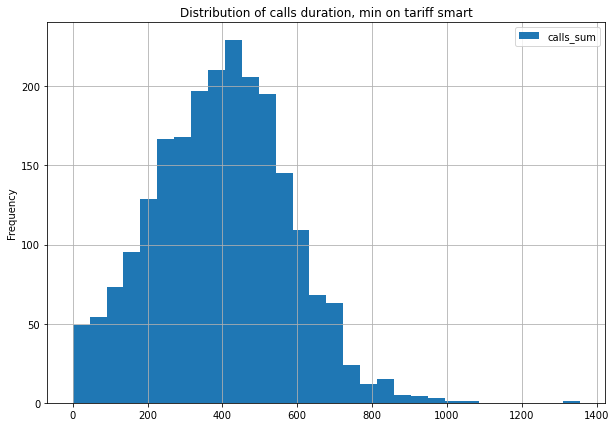

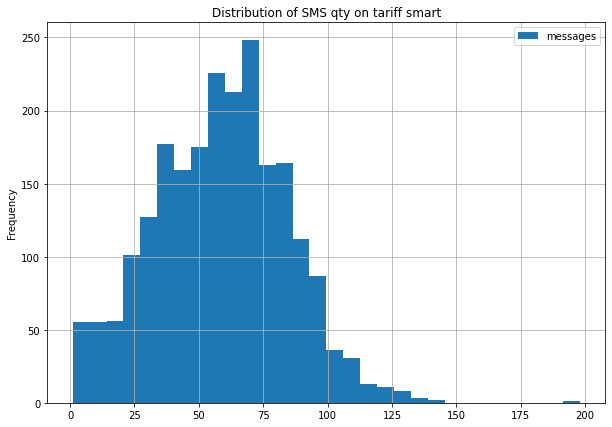

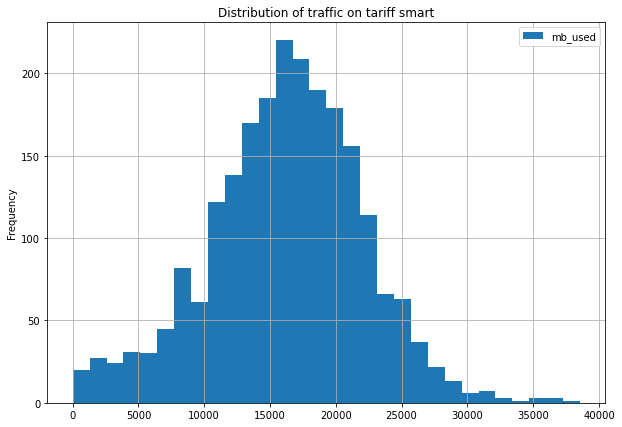

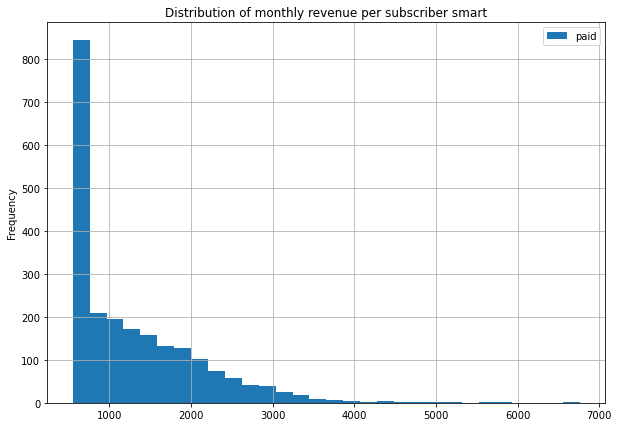

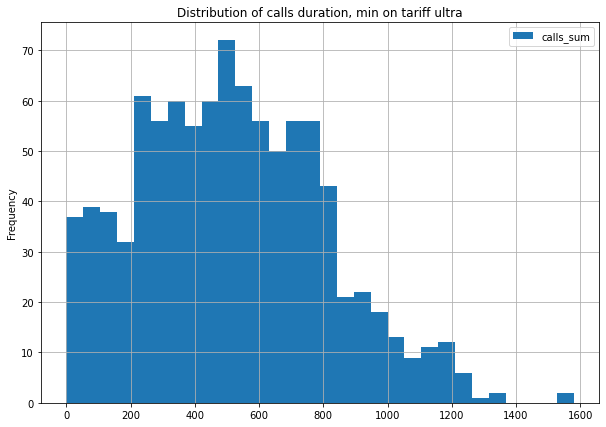

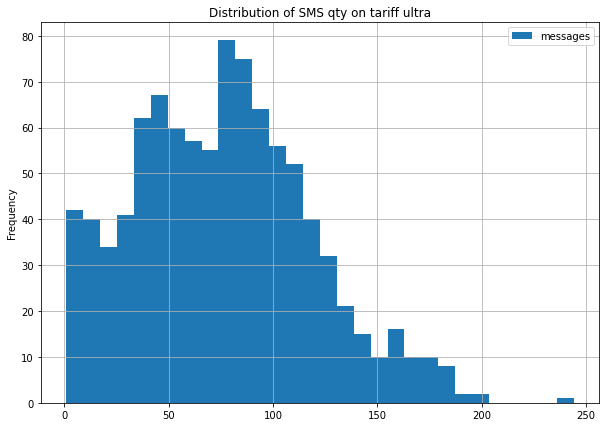

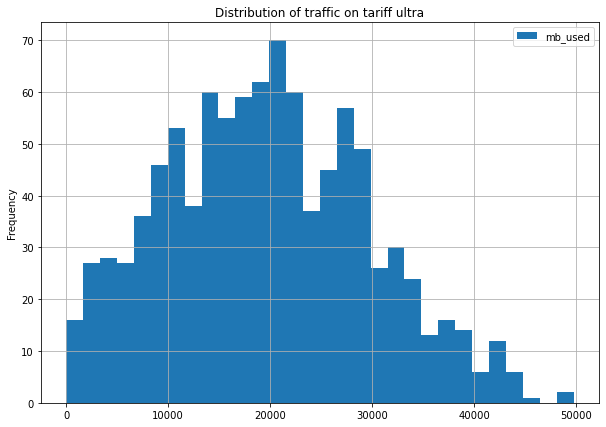

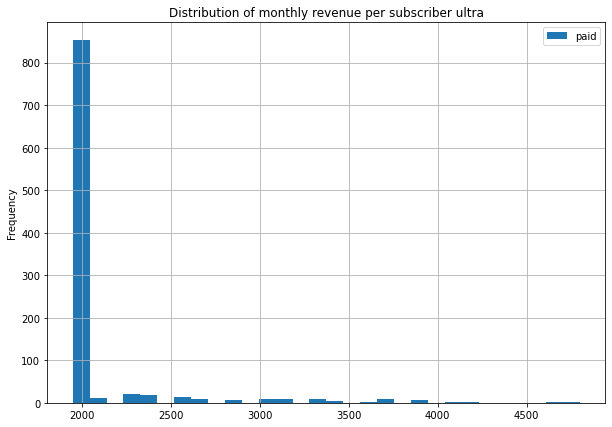

In [11]:
print('Description of "Smart" data:')
display(users_stat[users_stat.tariff == 'smart'].describe())
print()
print('Description of "Ultra" data:')
display(users_stat[users_stat.tariff == 'ultra'].describe())
print()

print('Mean, variance, и standard deviation of spending on different tariffs:')
display(users_stat.pivot_table(index = 'tariff', 
                               values = ['calls_sum', 'messages', 'mb_used', 'paid'], 
                               aggfunc=(np.var, np.std, np.mean)))
print()

#Building distribution for tariffs
for name, tariff_stat in users_stat.groupby('tariff'):
    tariff_stat.plot(kind='hist', 
                      y = 'calls_sum', 
                      bins = 30,
                      grid=True, 
                      figsize=(10,7),
                      title = 'Distribution of calls duration, min on tariff '+name)
    plt.show()
    #tariff_stat.hist(column='calls_sum', bins=30, density=True)
    
    tariff_stat.plot(kind='hist', 
                      y = 'messages',
                      bins=30,
                      grid=True,
                      figsize=(10,7),
                      title = 'Distribution of SMS qty on tariff '+name)
    plt.show()
    
    tariff_stat.plot(kind='hist', 
                      y = 'mb_used',
                      bins=30,
                      grid=True,
                      figsize=(10,7),
                      title = 'Distribution of traffic on tariff '+name)
    plt.show()
    
    tariff_stat.plot(kind='hist',
                    y='paid',
                    bins=30,
                    grid=True,
                    figsize=(10,7),
                    title = 'Distribution of monthly revenue per subscriber '+name)
    plt.show()
    

In [13]:
#Let's compare statistics of parameters for subscribers from Moscow and other regions

print('Description of data for subscribers in Moscow on both tariffs:')
display(users_stat[(users_stat.city == 'Москва')].describe())
print()
print('Description of data for regional subscribers on both tariffs:')
display(users_stat[(users_stat.city != 'Москва')].describe())
print()

print('Description of data for Smart subscribers in Moscow:')
display(users_stat[(users_stat.city == 'Москва') & (users_stat.tariff == 'smart')].describe())
print()
print('Description of data for regional Smart subscribers:')
display(users_stat[(users_stat.city != 'Москва') & (users_stat.tariff == 'smart')].describe())
print()

print('Description of data for Ultra subscribers in Moscow:')
display(users_stat[(users_stat.city == 'Москва') & (users_stat.tariff == 'ultra')].describe())
print()
print('Description of data for regional Ultra subscribers:')
display(users_stat[(users_stat.city != 'Москва') & (users_stat.tariff == 'ultra')].describe())
print()

Description of data for subscribers in Moscow on both tariffs:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,611.00,611.00,610.00,610.00,610.00,611.00,611.00
mean,"1,268.87",8.43,65.54,444.03,65.54,"17,964.36","1,546.60"
std,137.53,2.89,33.11,227.73,33.11,"7,844.98",751.55
min,"1,001.00",1.00,1.00,1.00,1.00,366.00,550.00
25%,"1,171.00",6.00,42.00,287.25,42.00,"12,613.00",778.50
50%,"1,291.00",9.00,64.00,426.00,64.00,"17,538.00","1,776.00"
75%,"1,385.00",11.00,85.75,586.50,85.75,"22,115.50","1,950.00"
max,"1,490.00",12.00,188.00,"1,249.00",188.00,"44,297.00","5,267.00"



Description of data for regional subscribers on both tariffs:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"2,605.00","2,603.00","2,564.00","2,564.00","2,564.00","2,592.00","2,605.00"
mean,"1,247.54",8.29,63.43,428.82,63.43,"17,102.86","1,521.54"
std,145.99,2.91,32.57,224.19,32.57,"7,428.83",809.56
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,120.00",6.00,41.00,271.75,41.00,"12,509.25",742.00
50%,"1,241.00",9.00,62.00,420.50,62.00,"16,874.50","1,589.00"
75%,"1,377.00",11.00,82.00,554.00,82.00,"21,242.00","1,950.00"
max,"1,499.00",12.00,244.00,"1,579.00",244.00,"49,746.00","6,764.00"



Description of data for Smart subscribers in Moscow:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,386.00,386.00,386.00,386.00,386.00,386.00,386.00
mean,"1,251.01",8.57,58.24,394.41,58.24,"16,018.59","1,239.17"
std,133.95,2.86,24.15,167.76,24.15,"5,611.91",752.53
min,"1,001.00",1.00,2.00,11.00,2.00,373.00,550.00
25%,"1,157.00",7.00,40.00,273.00,40.00,"12,552.75",580.00
50%,"1,260.00",9.00,57.50,386.00,57.50,"16,151.00",986.50
75%,"1,343.50",11.00,76.00,513.75,76.00,"19,848.25","1,695.25"
max,"1,490.00",12.00,128.00,968.00,128.00,"35,109.00","5,267.00"



Description of data for regional Smart subscribers:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,"1,844.00","1,843.00","1,837.00","1,837.00","1,837.00","1,842.00","1,844.00"
mean,"1,245.63",8.30,58.70,396.32,58.70,"16,257.55","1,295.67"
std,148.55,2.93,26.13,181.37,26.13,"5,913.39",831.03
min,"1,002.00",1.00,1.00,0.00,1.00,0.00,550.00
25%,"1,119.00",6.00,40.00,268.00,40.00,"12,718.00",583.00
50%,"1,232.00",9.00,60.00,404.00,60.00,"16,573.50","1,014.50"
75%,"1,378.00",11.00,76.00,516.00,76.00,"20,067.00","1,758.25"
max,"1,499.00",12.00,198.00,"1,355.00",198.00,"38,553.00","6,764.00"



Description of data for Ultra subscribers in Moscow:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,225.00,225.00,224.00,224.00,224.00,225.00,225.00
mean,"1,299.52",8.19,78.14,529.54,78.14,"21,302.45","2,074.00"
std,138.48,2.93,41.65,285.36,41.65,"9,785.22",350.10
min,"1,003.00",1.00,1.00,1.00,1.00,366.00,"1,950.00"
25%,"1,203.00",6.00,50.75,335.75,50.75,"13,753.00","1,950.00"
50%,"1,341.00",9.00,77.00,526.00,77.00,"21,471.00","1,950.00"
75%,"1,415.00",11.00,105.00,723.25,105.00,"28,678.00","1,950.00"
max,"1,476.00",12.00,188.00,"1,249.00",188.00,"44,297.00","4,050.00"



Description of data for regional Ultra subscribers:


,user_id,month,calls,calls_sum,messages,mb_used,paid
count,761.00,760.00,727.00,727.00,727.00,750.00,761.00
mean,"1,252.15",8.27,75.36,510.95,75.36,"19,178.95","2,068.86"
std,139.60,2.86,42.64,291.25,42.64,"9,944.13",383.55
min,"1,000.00",1.00,1.00,0.00,1.00,0.00,"1,950.00"
25%,"1,124.00",6.00,42.00,287.50,42.00,"11,779.75","1,950.00"
50%,"1,265.00",9.00,74.00,489.00,74.00,"18,623.50","1,950.00"
75%,"1,375.00",11.00,105.00,714.50,105.00,"25,984.00","1,950.00"
max,"1,495.00",12.00,244.00,"1,579.00",244.00,"49,746.00","4,800.00"


### Conclusions

1. Monthly amounts of calls, messages and Internet traffic on both tariffs have a normal distribution. There is a very slight skew on the Smart tariff to the left, and on Ultra - to the right.
2. More than half of Smart subscribers spend SMS and Internet in excess of tariff limits, and about a third spend more than the free minutes included in the package. Whereas the vast majority (~ 80%) of Ultra plan subscribers fit into the limits of their tariff.
3. The calculated average revenue in the samples is higher for Ultra (see hypothesis testing below), while the maximum revenue is observed in the sample for subscribers on the Smart tariff.

## Hipothesis Test

In [16]:
# Let's test the hypothesis that the average revenue of tariffs is different. H0 - average revenue is same
alpha = 0.05
results = st.ttest_ind(users_stat[users_stat.tariff == 'smart'].paid, users_stat[users_stat.tariff == 'ultra'].paid, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 1.527869541198527e-252
Rejecting the null hypothesis


In [15]:
#Let's test the hypothesis that the average revenue of subscribers from Moscow and other regions is different. H0 - average revenue is same
alpha = 0.05
results = st.ttest_ind(users_stat[users_stat.city == 'Москва'].paid, users_stat[users_stat.city != 'Москва'].paid, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.4652589993102004
Failed to reject the null hypothesis


### Conclusion

Samples for subscribers of two different tariff plans can be considered as samples from different populations. Therefore, we use the scipy.stats.ttest_ind method to compare them. Because revenue variances in two samples are different, parameter equal_var = False.

**Hypotheses:**
1. About revenue from subscribers on Smart and Ultra tariff plans:
    - Null hypothesis: The average revenue of subscribers on different different tariff plans is equal.
    - Alternative hypothesis: The average revenue of subscribers on different tariff plans varies.
2. On revenue from subscribers from Moscow and other regions.
    - Null hypothesis: The average revenue from subscribers from Moscow and other regions is equal.
    - Alternative hypothesis: The average revenue of subscribers from Moscow and other regions differs.

As a criterion for testing null hypotheses, we take the criterion p-value < level of statistical significance.

**Result of hypothesis testing:**

**one. The average revenue of the tariffs differs and is higher on the Ultra tariff.** The probability of obtaining such a difference in samples by chance is extremely small.
**2. The hypothesis that the average revenue of subscribers from Moscow and other regions differs has not been confirmed.** The probability of getting this or more difference in average values ​​(see above) is almost 50%.

## Overall Conclusion

1. The average monthly revenue per subscriber is higher for Ultra tariff subscribers.
2. Revenue from subscribers in Moscow and other regions does not differ.
3. More than half of Smart subscribers spend SMS and Internet in excess of tariff limits, and about a third spend more than the free minutes included in the package. Whereas the vast majority (~ 80%) of Ultra plan subscribers fit into the limits of their tariff.